## 학습 목표

- 생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기
- Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기
- Fashion MNIST 데이터셋의 의미를 알기
- 생성적 적대 신경망(GAN)의 구조와 원리를 이해하기
- 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기

## 여러 가지 생성 모델링 기법과 친해지기 (1) Pix2Pix
- 이미지 관련 모델
- paired data 필요
- 단순화된 input을 넣으면 ground truth를 반환하도록 학습

## 여러 가지 생성 모델링 기법과 친해지기 (2) CycleGAN

- 그림 <-> 실사 양방향으로 변환 가능(Pix2Pix는 한 방향)
- 스타일(?)을 학습해서 다른 것에 입히는 방식이라 labelling 필요 없음

## 여러 가지 생성 모델링 기법과 친해지기 (3) Neural Style Transfer
- Base image와 Style image 두 장을 놓고 새로운 이미지를 만들어 냄

## 패션을 디자인하려면? 먼저 패션을 배워야지! (2) 코드로 살펴보기

In [9]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


> fashion_mnist는 tensorflow 안에 모듈로 있다.  
> 분류 문제가 아니기 때문에 y(라벨) 데이터는 가져오지 않는다

In [10]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(original_train_x, _), (original_test_x, _) = fashion_mnist.load_data()

In [13]:
print("max pixel:", original_train_x.max())
print("min pixel:", original_train_x.min())

max pixel: 255
min pixel: 0


In [14]:
train_x = (original_train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [15]:
train_x.shape

(60000, 28, 28)

> 여기서 주의할 점은 딥러닝에서 이미지를 다룰 때는 `채널 수`도 필요함.  
> 그래서 4차원 tensor로 만들어줘야 함
> 그런데 RGB는 채널 3개이지만, 흑백은 채널이 1개이니 그렇게 변환

In [16]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

----------------------
----------------------
----------------------

> #### 실험
> - 한 번 3차원(가로, 세로, 채널)을 `plt.imshow()`에 넣어도 되는지 확인해보고 싶다.
> - 정규화된 사이즈가 달라도 이미지가 제대로 나오는지 확인해보고 싶다.

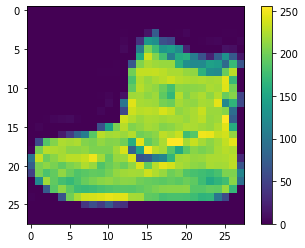

In [18]:
plt.imshow(original_train_x[0])
plt.colorbar()
plt.show()

In [19]:
original_train_x.shape

(60000, 28, 28)

In [20]:
original_train_x.dtype

dtype('uint8')

In [22]:
t = original_train_x.reshape(60000, 28, 28, 1)
t.shape

(60000, 28, 28, 1)

In [23]:
t.dtype

dtype('uint8')

In [25]:
t.astype('float32')
t.dtype

dtype('uint8')

In [26]:
t = t.astype('float32')
t.dtype

dtype('float32')

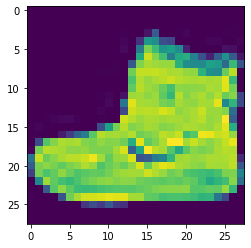

In [28]:
plt.imshow(original_train_x[0])

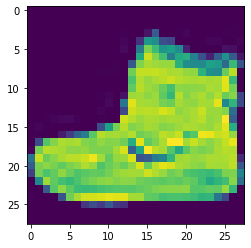

In [29]:
plt.imshow(t[0])

In [30]:
t.shape

(60000, 28, 28, 1)

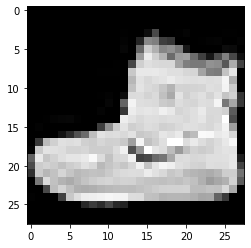

In [33]:
plt.imshow(t[0], cmap='gray')

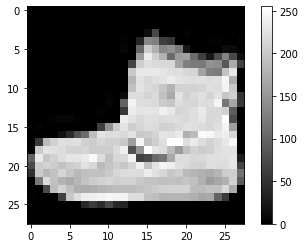

In [34]:
plt.imshow(t[0], cmap='gray')
plt.colorbar()
plt.show()

In [35]:
tt = t / 127.5
print(tt.max())
print(tt.min())

2.0
0.0


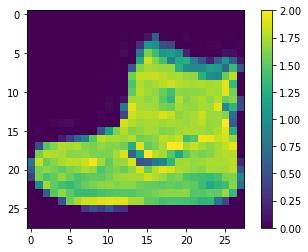

In [36]:
plt.imshow(tt[0])
plt.colorbar()
plt.show()

> #### 결과
> - 3차원으로 `plt.imshow()`에 넣어도 오류나지 않는다.
> - 값 스케일이 바뀌어도 `plt.imshow()`로서 이미지가 잘 나타난다.

----------------------
----------------------
----------------------

> 데이터 하나만 꺼내서 확인하기

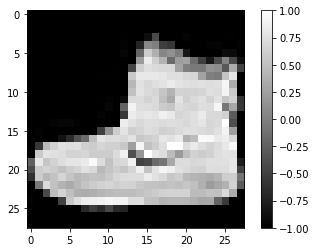

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

> 위의 컬러바를 통해 실제 값과 컬러의 분포를 확인할 수 있음  
> -1 ~ 1까지

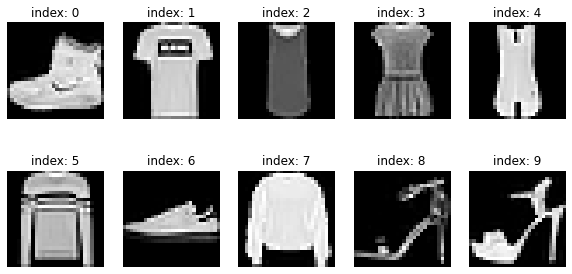

In [8]:
# 10개 확인
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

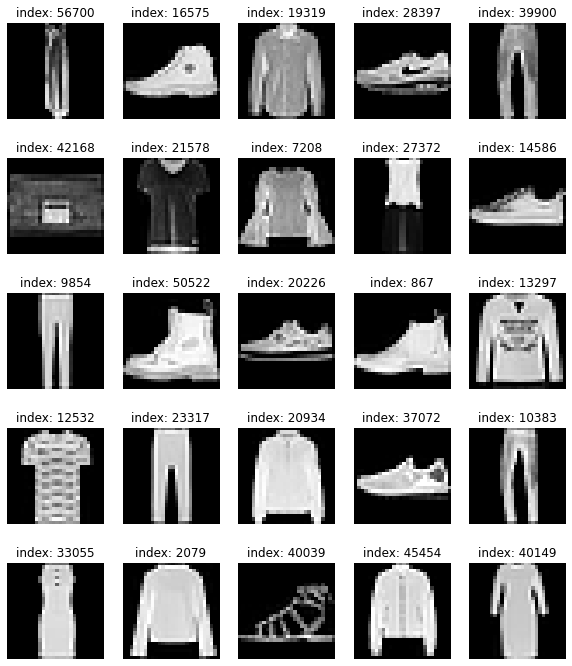

In [38]:
# 25개 랜덤으로 확인

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

> tf.data.Dataset 화 시켜서 매번 우리가 직접 섞지 않아도 되게끔 해주기

In [39]:
BUFFER_SIZE = 60000 # 전체 다 섞어주기
BATCH_SIZE = 256 # 미니배치 학습

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (1) GAN 이해하기

- 이후 소개하는 코드는 Tensorflow 2.0 Tutorial의 DCGAN 구현을 기반으로 상세한 설명을 추가함

In [42]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

#### 아이펠 설명

`make_generator_model`이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 했습니다.

함수 내부에서는 먼저 `tf.keras.Sequential()`로 모델을 시작한 후 레이어를 차곡차곡 쌓아줍니다.

여기에서 가장 중요한 레이어는 바로 `Conv2DTranspose` 레이어입니다. `Conv2DTranspose` 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다. 이 모델에서는 세 번의 `Conv2DTranspose` 층을 이용해 `(7, 7, 256)` → `(14, 14, 64)` → `(28, 28, 1)` 순으로 이미지를 키워나갑니다. 여기서 최종 사이즈인 `(28, 28, 1)`은 우리가 준비했던 데이터셋과 형상이 동일합니다.

레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, `BatchNormalization` 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다. 또한 중간층들의 활성화 함수는 모두 `LeakyReLU`를 사용하였습니다. 다만 마지막 층에는 활성화 함수로 `tanh`를 사용하는데, 이는 우리가 `-1 ~ 1` 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

In [43]:
# generator 모델 생성
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

> (1, 100) 형태를 갖는 열벡터를 만들어서 인풋으로 넣어줄 예정  
> 아직 훈련되지 않아서 별 의미없는 output이 나올 것임

In [44]:
noise = tf.random.normal([1, 100])

#### 아이펠 설명
텐서플로우 2.0 이후 버전에서는 레이어와 모델에 `call` 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됩니다 (내부적으로는 생성자의 `call` 함수가 호출됩니다).

단, 지금은 학습하는 중이 아니니 `training=False`를 설정해 주어야 합니다! `Batch Normalization` 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 `training=False`을 주어야 올바른 결과를 얻을 수 있습니다.

In [45]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 3.96854639e-01, -9.03411031e-01, -1.03277966e-01,
        -1.33564128e-02,  1.02616894e+00, -1.47861993e+00,
         3.29661757e-01, -1.76281497e-01, -9.49293792e-01,
         4.59632784e-01,  7.27090836e-01, -3.15581769e-01,
         1.91859746e+00,  5.37751615e-01,  2.14032784e-01,
         1.17724679e-01,  3.75476182e-01,  4.61798199e-02,
         1.34195030e+00, -2.33857036e-01,  1.39860439e+00,
        -2.01601014e-01,  7.66258061e-01, -3.12837660e-01,
         1.42178297e+00,  2.79477268e-01,  1.56311941e+00,
         1.09847806e-01,  1.99261144e-01,  1.65953999e-03,
        -1.13957787e+00,  1.91445518e+00, -1.36811960e+00,
        -4.50607866e-01,  4.37245041e-01,  7.96103597e-01,
        -6.59848750e-01, -9.80238736e-01, -4.69153263e-02,
        -7.39774466e-01, -1.93865955e-01,  4.70025033e-01,
         1.86829254e-01,  3.37503016e-01,  9.14283752e-01,
         1.20782495e-01, -2.56878942e-01, -1.57627368e+00,
      

In [46]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

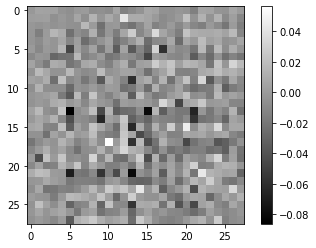

In [47]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [49]:
generated_image[0, :, :, :].shape

TensorShape([28, 28, 1])

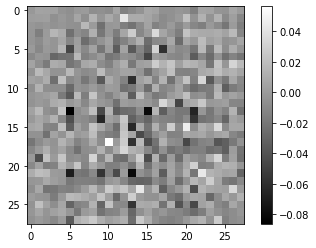

In [48]:
plt.imshow(generated_image[0, :, :, :], cmap='gray')
plt.colorbar()
plt.show()

#### 아이펠 설명
역시 -1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있습니다.

아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 나타나...

## 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (3) 판별자 구현하기

In [50]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

판별자 또한 `make_discriminator_model` 함수로 구현하였습니다.

`Conv2DTranspose` 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
첫 번째 Conv2D 층에서 입력된 `[28, 28, 1]` 사이즈의 이미지는 다음 층을 거치며 `(28, 28, 1) → (14, 14, 64) → (7, 7, 128)`까지 줄어들게 됩니다.

마지막에는 `Flatten` 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 `7x7x128=627`2, 즉 `(1, 6272)` 형상의 벡터로 변환합니다. 이는 생성자의 `Reshape` 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 `Dense Layer`를 거쳐 단 하나의 값을 출력하게 됩니다.

그럼 판별 모델을 `discriminator`라는 변수 이름으로 생성하고, 모델 세부 내용인 `summary`를 출력해 봅시다.

In [51]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

> - 아까 생성한 이미지를 넣으면 어떤 값이 나오는지 확인  
> - 물론 아직은 의미 없는 값이 나올 것임

In [52]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00516815]], dtype=float32)>

----------------
----------------
----------------

#### 실험
> - `padding='same'` 의 원리를 알고 싶다.
> - `strides=1`일 때는 input과 동일한 shape이 나오는 걸 알겠는데,
> - `strides=2`이상 되면 `same`이 무슨 의미일까?

In [55]:
ten = tf.zeros([1, 28, 28, 1])

con1 = tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same')
out = con1(ten)
out.shape

TensorShape([1, 14, 14, 32])

In [56]:
ten = tf.zeros([1, 28, 28, 1])

con1 = tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='valid')
out = con1(ten)
out.shape

TensorShape([1, 12, 12, 32])

In [57]:
ten = tf.zeros([1, 28, 28, 1])

con1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='valid')
out = con1(ten)
out.shape

TensorShape([1, 26, 26, 32])

In [58]:
ten = tf.zeros([1, 28, 28, 1])

con1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='valid')
out = con1(ten)
out.shape

TensorShape([1, 13, 13, 32])

In [59]:
ten = tf.zeros([1, 28, 28, 1])

con1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')
out = con1(ten)
out.shape

TensorShape([1, 14, 14, 32])

In [60]:
ten = tf.zeros([1, 28, 28, 1])

con1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=3, padding='same')
out = con1(ten)
out.shape

TensorShape([1, 10, 10, 32])

In [61]:
ten = tf.zeros([1, 28, 28, 1])

con1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=3, padding='valid')
out = con1(ten)
out.shape

TensorShape([1, 9, 9, 32])

#### feedback
> - 결론적으로 `same`을 하면 strides가 2이상일 때 9, 11 같은 output shape을 10, 12 같이 even하게 만들어주는 것 같다.

## 생성 모델이 똑똑해지기 위한 기나긴 여정 (1) 손실함수와 최적화 함수

#### 아이펠 설명
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다.
교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이죠. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피`(binary cross entropy)`를 사용할 것입니다.

자, 이쯤에서 다시 생성자와 판별자의 목적이 무엇이었는지 한번 정리해 볼까요? 생성자는 자기가 생성한 `Fake Image`를 판별자가 진짜라고 판단하도록 속이고 싶어 합니다. 판별자는 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것이 목표입니다.

좋습니다!  
그렇다면 `Real Image`에 대한 라벨을 `1`, `Fake Image`에 대한 라벨을 `0`으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠죠.

`생성자` : `판별자`가 Fake Image에 대해 판별한 값, 즉 `D(fake_image)` 값이 `1`에 가까워지는 것  
`판별자` : Real Image 판별값, 즉 `D(real_image)`는 `1`에, Fake Image 판별값, 즉 `D(fake_image)`는 `0`에 가까워지는 것  
결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요! 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해 봅시다.

손실함수에 사용할 교차 엔트로피 함수는 `tf.keras.losses` 라이브러리 안에 있습니다.

다만, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠.

그런데 tf.keras.losses의 `BinaryCrossEntropy` 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다. 따라서 `from_logits`를 `True`로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.

In [63]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 아이펠 설명

그럼, 이제 cross_entropy를 활용해 계산할 loss들은 `fake_output`와 `real_output`, 두 가지를 활용합니다.

`fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 `D(fake_image)`
`real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 `D(real_image)`
그럼 이제, fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

바로 `tf.ones_like()`와 `tf.zeros_like()` 함수를 활용하면 됩니다.
이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다.
어떤 식으로 활용되는지, 한번 실험해 볼까요?

In [64]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

### generator_loss

그러면 `generator_loss`는 다음과 같이 구현할 수 있겠군요.

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 `tf.ones_like`와의 교차 엔트로피값을 계산하면 됩니다.
즉, `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 `작은 값`을 가집니다.

In [65]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss

#### 아이펠 설명

반면, `discriminator_loss`는 `real_output` 값은 `1`에 가까워지기를, `fake_output` 값은 `0`에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!

최종 `discriminator_loss 값은 이 둘을 더한 값`입니다.

In [67]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

#### 아이펠 설명

한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 `accuracy`를 따로 계산해서 비교해 보는 것이 매우 유용합니다.

만약 판별자가 real output과 fake output을 accuracy가 `1.0`에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 `쉽게 판별`해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 `0.5`에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [68]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같습니다.

ex.) `real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])` 라면,

- (1) `tf.math.greater_equal(real_output, tf.constant([0.5])` : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> `tf.Tensor([False, False, True, True])`
- (2) `tf.cast( (1), tf.float32)` : (1)의 결과가 `True이면 1.0`, `False이면 0.0으로 변환` - >> `tf.Tensor([0.0, 0.0, 1.0, 1.0])`
- (3) `tf.reduce_mean( (2))` : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> `0.5`

### 최적화 함수(optimizer)

중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [70]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

샘플은 한 번에 16장을 생성하도록 하겠습니다.  
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 `seed` 노이즈를 만들어두어야 합니다.
즉, 100차원의 노이즈를 총 16개, `(16, 100)` 형상의 벡터를 만들어 두도록 하겠습니다.

In [71]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [75]:
seed[:1, :]

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.2627834 ,  0.38518155, -0.9515627 ,  0.0875157 , -0.32265577,
         0.25068024, -0.11028544, -0.24491279,  0.6183259 ,  0.83429825,
         0.7682573 , -1.4271178 , -2.0610085 ,  1.0442251 ,  2.1625097 ,
        -0.26752424,  1.4999356 , -0.22690766,  0.9004858 ,  0.6464795 ,
         1.3431352 , -0.8213151 , -0.23106466, -1.1284685 ,  0.6144815 ,
        -0.06441844, -0.03768314,  0.5690817 ,  0.04751236, -0.16303144,
        -1.355594  , -0.5115844 , -0.31575105, -2.0118873 ,  1.3598229 ,
         1.1545432 , -0.70045036,  0.1300467 ,  0.74650246,  0.5513549 ,
        -0.02698994, -0.77925885,  0.8454625 ,  2.1379788 ,  1.5662848 ,
         0.64801633, -1.4340749 , -0.03694333,  0.25454614, -0.3965547 ,
         0.23265162,  1.7766    , -0.74997395,  1.1660575 , -0.831553  ,
         1.2857306 ,  0.680116  ,  0.35116115,  1.0427655 , -0.1990515 ,
        -0.49894363,  0.6006104 , -0.21008171,  1.0238844 , -0.30149165,
 

##  생성 모델이 똑똑해지기 위한 기나긴 여정 (2) 훈련과정 설계

그렇다면 이제 진짜 훈련을 위한 코드를 만들어 보도록 합시다.

하나의 미니 배치 당 진행할 `train_step` 함수를 먼저 만들어야 합니다.
텐서플로우 2.0 이후부터는 1.x의 이전 버전과 다르게, session을 사용하지 않습니다. 대신, 학습시킬 훈련 함수 위에 `@tf.function` 이라는 데코레이터를 붙여서 사용합니다. 이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해줍니다.

데코레이터의 개념은 어렵지 않으시더라도 `@tf.function` 이 정확히 어떤 역할을 해주는 것인지 명확히 이해가 안 되실 수도 있을 것 같습니다. Tensorflow Tutorial에는 이 데코레이터의 역할을 다음과 같이 정의하고 있습니다.

> tf.function : Compiles a function into a callable TensorFlow graph

아래 두 코드를 실행해 보면 위 정의의 의미가 명확해질 것입니다.

In [77]:
import numpy as np
import tensorflow as tf

def f(x, y):
    print(type(x))
    print(type(y))
    return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [79]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
    print(type(x))
    print(type(y))
    return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

`Numpy array` 입력 x, y를 동일하게 사용했지만 f(x,y)의 결과 타입은 다릅니다. `@tf.function` 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 `graph 노드`가 될 수 있는 타입으로 자동 변환됩니다. 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것 같습니다.

In [80]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기
- (4) `generated_images` 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) `discriminator` 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : `gen_tape`와 `disc_tape`를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보죠.
아까 만들어 놓았던 고정된 `seed`를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

In [87]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 `matplotlib`으로 시각화해주는 과정이 담겨 있는데, 어딘가 익숙하지 않나요?

바로 우리가 위에서 해봤던, subplot을 이용해서 총 16개의 sample을 시각화하는 과정입니다. 16개이므로 4행 4열로 나누어 `subplot(4, 4, i+1)`로 시각화하는 것이죠.

또한, plt에 저장되어 보이는 이미지를 `plt.savefig`로 간단히 파일로 저장합니다.


학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 `loss`와 `accuracy` 그래프를 빼놓을 수 없겠습니다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다. `train_step()` 함수가 리턴하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 이상 4가지 값을 `history`라는 `dict` 구조에 리스트로 저장하고 있다가 매 `epoch`마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 `history['gen_loss']`로 접근할 수 있는 list로 관리할 예정입니다.

In [88]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.

`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적입니다. 아주 오랜 시간 동안 학습을 시켰는데 네트워크가 끊긴다거나, 예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없을 테니까요..!

`checkpoint`에는 optimizer와 `생성자, 판별자`를 모두 넣어 저장합니다. 정확히는 생성자와 판별자가 학습한 모델 `가중치`를 저장하는 것이죠. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.

checkpoint 모델을 저장하기 위해 작업환경 내에 `training_checkpoints` 라는 디렉토리를 사용하겠습니다.

In [89]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 생성 모델이 똑똑해지기 위한 기나긴 여정 (3) 학습 시키기

자.. 이제 대망의 모델 학습입니다.

지금까지 한 단계를 학습하는 `train_step`, 샘플 이미지를 생성하고 저장하기 위한 `generate_and_save_images()`, 학습 과정을 시각화하는 `draw_train_history()`, 그리고 모델까지 저장하기 위한 `checkpoint`까지 모두 준비가 되었으니 이것들을 한곳에 합치기만 하면 됩니다.

한번 확인해 볼까요!

In [90]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

출력하고자 하는 print문과 몇 번마다 출력하는지에 대한 구문을 원하는 대로 수정해서 마음에 드는 형태로 확인해 보세요!

그러면 모델을 저장하는 간격을 담당하는 `save_every`와 전체 학습 에포크를 결정하는 `EPOCHS` 파라미터도 설정해 준 후 훈련시켜 보도록 하겠습니다!



본 학습은 이미지를 활용한 것이기 때문에 CPU 환경에서는 매우 느릴 수 있습니다.
RTX2070 또는 구글 Colab의 T4 정도 사양의 경우 1 Epoch 당 10초가 걸리는 반면, 일반적인 CPU 환경에서는 최소 3분에서 10분 이상이 걸릴 수 있으므로 최대한 GPU 환경에서 실습해 보는 것을 추천합니다.

이제 다음과 같이 train() 함수를 실행시키면 드디어 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인할 수 있습니다!

In [91]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

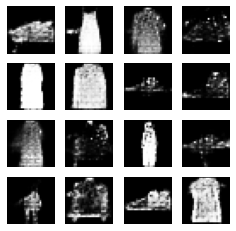

Time for training : 1495 sec


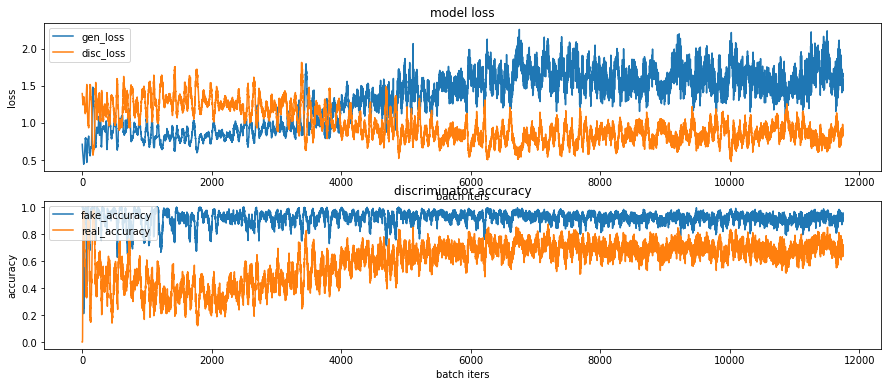

CPU times: user 7min 7s, sys: 46.8 s, total: 7min 54s
Wall time: 24min 56s


In [92]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

학습이 성공적으로 진행되었나요?

만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻입니다.

보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 합니다. 결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보세요!
과연 생성 모델이 이전에는 없던 새로운 디자인의 패션을 만들어내는 것을 확인할 수 있을 거예요..! (물론 시간은 그와 비례하게 늘어나겠죠..?)

어쩌면 단순히 학습 수행 시간만 늘리는 것보다, 모델 구조나 학습 방법을 바꾸어 봐야 할 수도 있습니다. 그래프를 유심히 보면서 학습 결과가 더 이상 개선되고 있지 않은지 여부를 지속적으로 살펴봅시다.

## 학습과정 시각화하기

학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보겠습니다. 더욱 생생한 학습 진행 과정을 확인해 볼 수 있을 테니까요!

GIF 파일은 우리가 오래전에 import 해놓았던 `imageio` 라이브러리를 활용해 만들 수 있습니다.
`imageio.get_writer`를 활용해서 파일을 열고, 거기에 `append_data`로 이미지를 하나씩 붙여나가는 방식입니다.
아래 코드가 무사히 실행되면, `fasion_mnist_dcgan.gif` 파일이 저장되어 있는 것을 확인할 수 있을 겁니다!

In [93]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1317797 Feb  8 07:14 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
